# Import libraries

In [1]:

from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.preprocessing.dataLoader_vi import SiameseNetworkDataset
from src.ml.own_network import SiameseNetworkOwn
from src.ml.resNet18 import SiameseNetwork
from src.ml.loss_utils import ContrastiveLoss, ArcFaceLoss, MultiSimilarityLoss
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
import torch.nn.functional as F

# 1. Load the data

In [ ]:
import yaml

# Load config from YAML
with open("config/config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract sections
PRE = config["PREPROCESSING"]
TRAIN = config["TRAINING"]

# Set constants from preprocessing config
IMAGE_DIR = PRE["image_dir"]
LABEL_FILE = PRE["label_file"]
PARTITION_FILE = PRE["partition_file"]
BATCH_SIZE = PRE["batch_size"] #16
M_PER_SAMPLE = PRE["m_per_sample"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set constants from training config
LR = TRAIN["lr"]
SCHEDULING = TRAIN["scheduling"]
WEIGHT_DECAY = TRAIN["weight_decay"]
NUM_EPOCHS = TRAIN["num_epochs"]
PATIENCE = TRAIN["patience"]
LOSS_TYPE = "arcface"
DATASET_NAME = "celebA"# "celebA" # ATT
NUM_IDENTITY = 200

In [3]:
def plot_all(train_loader):
    # Assuming train_loader uses FilteredCelebADataset with remapped labels

    # Access the underlying dataset from train_loader
    train_dataset = train_loader.dataset

    # Collect one example image per unique label
    unique_labels = sorted(set(train_dataset.labels))
    label_to_img = {}

    for idx, label in enumerate(train_dataset.labels):
        if label not in label_to_img:
            label_to_img[label] = train_dataset[idx][0]  # Assuming dataset[idx] returns (image, label)

    # Plot all unique labels with their example images
    num_labels = len(unique_labels)
    cols = 10
    rows = (num_labels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()

    for i, label in enumerate(unique_labels):
        img = label_to_img[label].permute(1, 2, 0).numpy()

        # Denormalize (if your dataset applies normalization)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean
        img = img.clip(0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
if DATASET_NAME == "celebA":
    # Load datasets
    train_loader, val_loader, test_loader = get_partitioned_dataloaders(
        image_dir=IMAGE_DIR,
        label_file=LABEL_FILE,
        partition_file=PARTITION_FILE,
        m_per_sample=M_PER_SAMPLE,
        batch_size=BATCH_SIZE,
        num_identities=NUM_IDENTITY,
        seed=42
    )
    # plot_all(train_loader=train_loader)
else:
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root="data/v2/data/faces/training/")

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])

    # Initialize the network
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transformation)
    train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/validation/")
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transformation)
    val_loader = DataLoader(siamese_dataset, num_workers=0, batch_size=BATCH_SIZE, shuffle=True)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/testing/")
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transformation)
    test_loader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

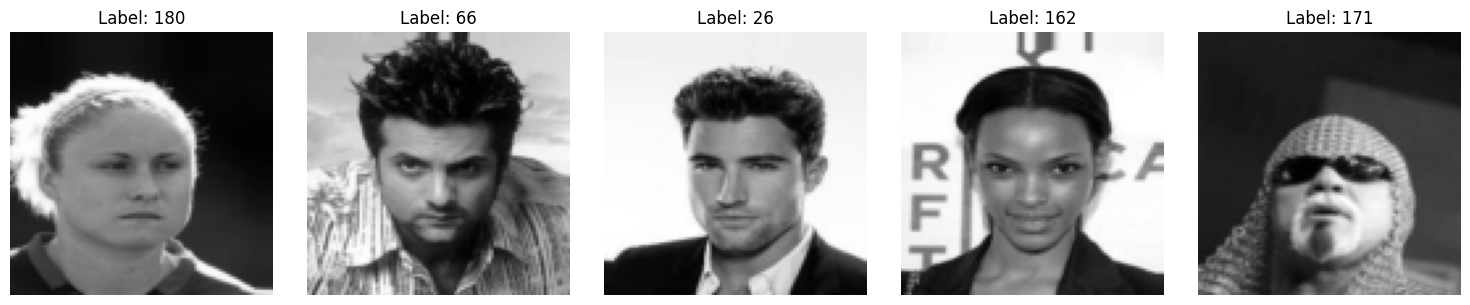

In [5]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(15, 3))

for i in range(5):
    sample = test_loader.dataset[i]
    image, label = sample[0], sample[3]  # image is first, label is fifth

    # Convert image to numpy
    if isinstance(image, torch.Tensor):
        if image.ndim == 3 and image.shape[0] == 1:  # grayscale
            image = image.squeeze().numpy()
            cmap = 'gray'
        elif image.ndim == 3 and image.shape[0] == 3:  # RGB
            image = image.permute(1, 2, 0).numpy()
            cmap = None
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
    else:
        cmap = 'gray'

    # Convert label to int
    if isinstance(label, torch.Tensor):
        label = label.item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap=cmap)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
num_batches_val = len(val_loader)
print(f"Number of batches in validation dataloader: {num_batches_val}")
num_samples_train = len(train_loader.dataset)
num_batches_train = len(train_loader)
print(f"Training samples: {num_samples_train}, Batches: {num_batches_train}")

Number of batches in validation dataloader: 38
Training samples: 2803, Batches: 175


# Create the model

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#net = SiameseNetwork().to(DEVICE)
net = SiameseNetworkOwn().to(DEVICE)

# Train Model

In [8]:
loss_type = LOSS_TYPE

if loss_type == "contrastive":
    criterion = ContrastiveLoss(margin=20).to(DEVICE)
elif loss_type == "arcface":
    criterion = ArcFaceLoss(num_classes=NUM_IDENTITY, embedding_size=256, margin=0.5, scale=64).to(DEVICE)
elif loss_type == "multisimilarity":
    import pytorch_metric_learning.losses as losses
    criterion = losses.MultiSimilarityLoss(alpha=70, beta=40, base=0.5).to(DEVICE)


In [9]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [10]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)                      # Python random module
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU (single GPU)
    torch.cuda.manual_seed_all(seed)       # PyTorch GPU (all GPUs if you use DataParallel)
    
    # For deterministic behavior (may be slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this once at the start of your script (before model init and training)
# set_seed(1234)

Epoch 50/50 [Training]: 100%|██████████| 175/175 [00:11<00:00, 15.76it/s, Train Loss=0.1805, Val Loss=0.3187]


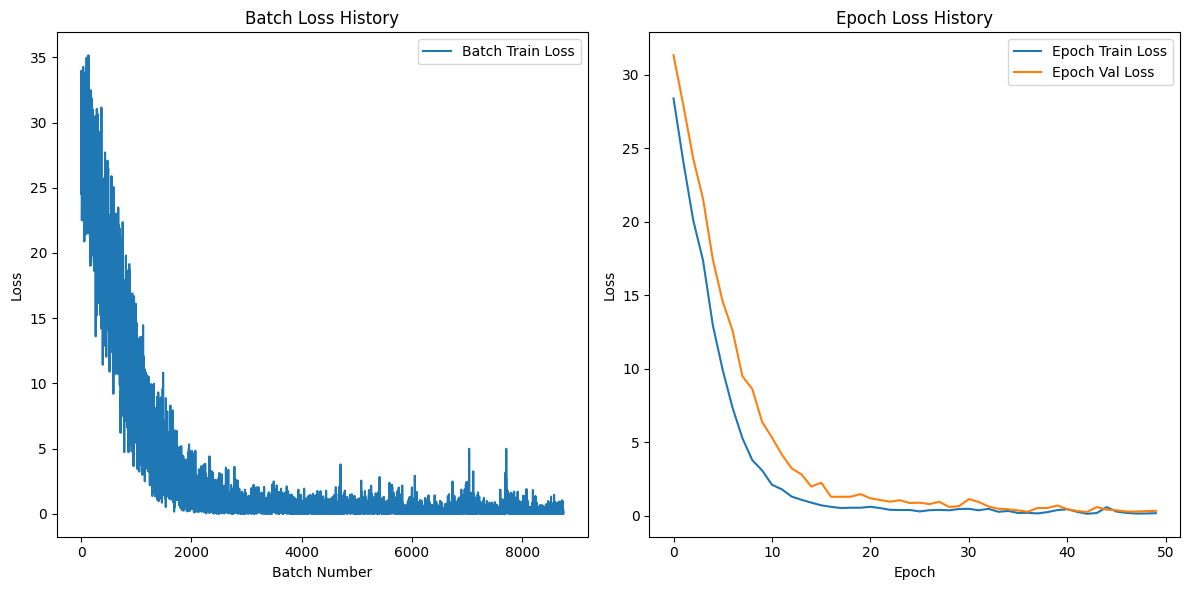

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize lists to store losses
batch_loss_history = []
batch_val_loss_history = []
epoch_loss_history = []
epoch_val_loss_history = []
iteration_number = 0
NUM_EPOCHS = 50

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(NUM_EPOCHS):
    net.train()
    cum_loss = 0
    pbar = tqdm(enumerate(train_loader, 0), total=len(train_loader),
                desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Training]", leave=True)

    for i, (img0, img1, label, label0, label1) in pbar:
        img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)
        label0, label1 = label0.to(DEVICE), label1.to(DEVICE)

        optimizer.zero_grad()
        output1, output2 = net(img0, img1)

        if loss_type == "contrastive":
            loss = criterion(output1, output2, label)
        elif loss_type == "multisimilarity":
            embeddings = torch.cat([output1, output2])
            labels = torch.cat([label0, label1])
            loss = criterion(embeddings, labels)
        elif loss_type == "arcface":
            loss = criterion(output1, output2, label0, label1)

        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        batch_loss_history.append(loss.item())  # Add batch loss to history

        avg_train_loss = cum_loss / (i + 1)
        
        # Validation at the end of each batch (optional, might be slow)
        # If you want validation per batch, uncomment this section
        """
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_img0, val_img1, val_label, val_label0, val_label1 in val_loader:
                val_img0, val_img1, val_label = val_img0.to(DEVICE), val_img1.to(DEVICE), val_label.to(DEVICE)
                val_label0, val_label1 = val_label0.to(DEVICE), val_label1.to(DEVICE)

                val_output1, val_output2 = net(val_img0, val_img1)

                if loss_type == "contrastive":
                    val_batch_loss = criterion(val_output1, val_output2, val_label)
                elif loss_type == "multisimilarity":
                    val_embeddings = torch.cat([val_output1, val_output2])
                    val_labels = torch.cat([val_label0, val_label1])
                    val_batch_loss = criterion(val_embeddings, val_labels)
                elif loss_type == "arcface":
                    val_batch_loss = criterion(val_output1, val_output2, val_label0, val_label1)

                val_loss += val_batch_loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        batch_val_loss_history.append(avg_val_loss)  # Add batch validation loss to history
        net.train()
        """

        # Update progress bar
        pbar.set_postfix({
            'Train Loss': f"{avg_train_loss:.4f}",
            'Val Loss': f"{epoch_val_loss_history[-1]:.4f}" if epoch_val_loss_history else '--'
        })

    # End of epoch - store average losses
    epoch_loss_history.append(avg_train_loss)
    
    # Validation phase at end of epoch
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img0, img1, label, label0, label1 in val_loader:
            img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)
            label0, label1 = label0.to(DEVICE), label1.to(DEVICE)

            output1, output2 = net(img0, img1)

            if loss_type == "contrastive":
                loss = criterion(output1, output2, label)
            elif loss_type == "multisimilarity":
                embeddings = torch.cat([output1, output2])
                labels = torch.cat([label0, label1])
                loss = criterion(embeddings, labels)
            elif loss_type == "arcface":
                loss = criterion(output1, output2, label0, label1)

            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    epoch_val_loss_history.append(avg_val_loss)
    
    # Update progress bar with final validation loss for this epoch
    pbar.set_postfix({
        'Train Loss': f"{avg_train_loss:.4f}",
        'Val Loss': f"{avg_val_loss:.4f}"
    })
    pbar.close()

    #scheduler.step()

# Plotting the losses
plt.figure(figsize=(12, 6))

# Plot batch losses if we tracked them
if batch_loss_history:
    plt.subplot(1, 2, 1)
    plt.plot(batch_loss_history, label='Batch Train Loss')
    if batch_val_loss_history:
        plt.plot(batch_val_loss_history, label='Batch Val Loss')
    plt.title('Batch Loss History')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()

# Plot epoch losses
plt.subplot(1, 2, 2)
plt.plot(epoch_loss_history, label='Epoch Train Loss')
plt.plot(epoch_val_loss_history, label='Epoch Val Loss')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save checkpoint
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': epoch_loss_history,
    'val_loss': epoch_val_loss_history,
    'batch_train_loss': batch_loss_history,
    'batch_val_loss': batch_val_loss_history if 'batch_val_loss_history' in locals() else None,
}, f'models/checkpoint_{DATASET_NAME}_{LOSS_TYPE}.pth')

✅ Average Intra-Class Cosine Similarity: 0.7193
✅ Average Inter-Class Cosine Similarity: 0.0039


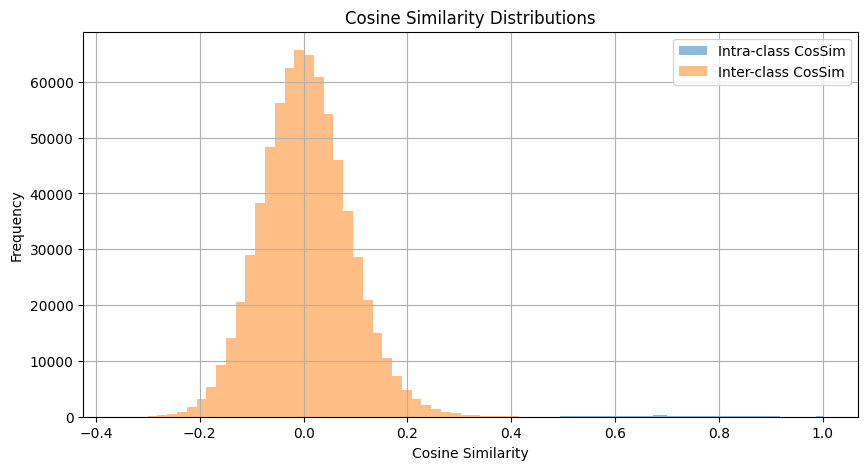

In [15]:
from collections import defaultdict
from itertools import combinations
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set model to evaluation mode
net.eval()

# Collect embeddings and labels from validation set
all_embeddings = []
all_labels = []

with torch.no_grad():
    for img0, img1, _, label0, label1 in val_loader:
        img0, img1 = img0.to(DEVICE), img1.to(DEVICE)
        label0, label1 = label0.to(DEVICE), label1.to(DEVICE)
        output1, output2 = net(img0, img1)

        all_embeddings.append(torch.cat([output1, output2]))
        all_labels.append(torch.cat([label0, label1]))

# Concatenate all embeddings and labels
all_embeddings = torch.cat(all_embeddings)  # shape: [N, D]
all_labels = torch.cat(all_labels)          # shape: [N]

# Normalize embeddings for cosine similarity
all_embeddings = F.normalize(all_embeddings, p=2, dim=1)

# Group embeddings by class
class_to_embeddings = defaultdict(list)
for emb, label in zip(all_embeddings, all_labels):
    class_to_embeddings[label.item()].append(emb)

for key in class_to_embeddings:
    class_to_embeddings[key] = torch.stack(class_to_embeddings[key])

# Compute intra-class cosine similarities
intra_sims = []
for emb_list in class_to_embeddings.values():
    if len(emb_list) < 2:
        continue
    for i, j in combinations(range(len(emb_list)), 2):
        sim = F.cosine_similarity(emb_list[i].unsqueeze(0), emb_list[j].unsqueeze(0))
        intra_sims.append(sim.item())

# Compute inter-class cosine similarities
inter_sims = []
label_keys = list(class_to_embeddings.keys())
for i in range(len(label_keys)):
    for j in range(i+1, len(label_keys)):
        emb_i = class_to_embeddings[label_keys[i]]
        emb_j = class_to_embeddings[label_keys[j]]
        for e1 in emb_i:
            for e2 in emb_j:
                sim = F.cosine_similarity(e1.unsqueeze(0), e2.unsqueeze(0))
                inter_sims.append(sim.item())

# Compute statistics
avg_intra_sim = sum(intra_sims) / len(intra_sims)
avg_inter_sim = sum(inter_sims) / len(inter_sims)

print(f"✅ Average Intra-Class Cosine Similarity: {avg_intra_sim:.4f}")
print(f"✅ Average Inter-Class Cosine Similarity: {avg_inter_sim:.4f}")

# Optional: Visualize distributions
plt.figure(figsize=(10, 5))
plt.hist(intra_sims, bins=50, alpha=0.5, label='Intra-class CosSim')
plt.hist(inter_sims, bins=50, alpha=0.5, label='Inter-class CosSim')
plt.title("Cosine Similarity Distributions")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
! pip install umap-learn

Sample counts per selected label:
Label 49: 9 samples
Label 79: 11 samples
Label 121: 3 samples
Label 181: 16 samples
Label 81: 3 samples
Label 158: 6 samples
Label 141: 4 samples
Label 132: 13 samples
Label 113: 4 samples
Label 31: 9 samples
Label 148: 6 samples
Label 87: 2 samples
Label 147: 4 samples
Label 102: 1 samples
Label 182: 9 samples
Label 134: 11 samples
Label 53: 10 samples
Label 28: 8 samples
Label 3: 11 samples
Label 154: 6 samples
Label 8: 17 samples
Label 65: 3 samples
Label 29: 8 samples
Label 140: 5 samples
Label 133: 10 samples
Label 40: 1 samples
Label 95: 4 samples
Label 126: 9 samples
Label 7: 6 samples
Label 166: 8 samples
Running t-SNE with perplexity=30 on 217 samples...


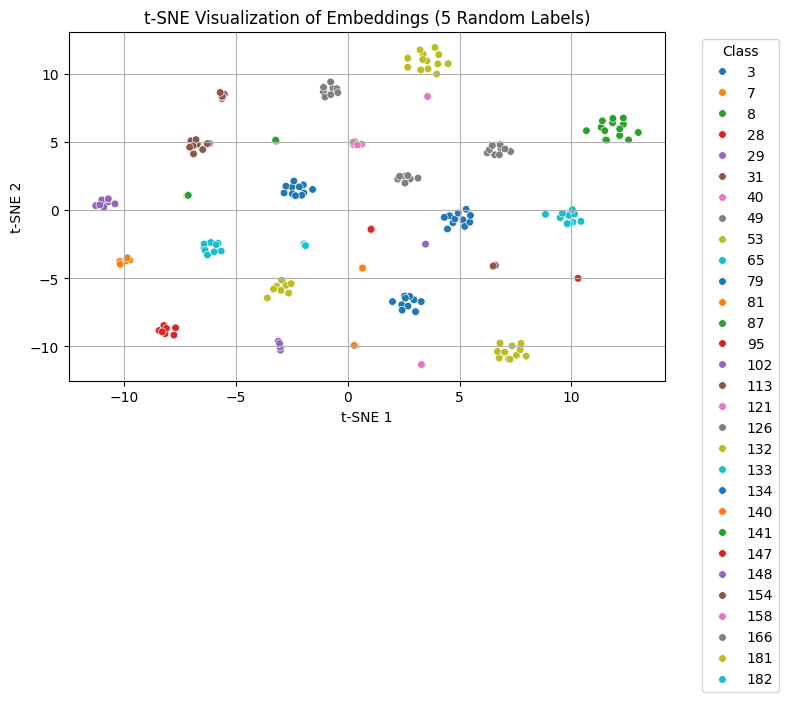

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
num = 30
# Convert tensors to NumPy arrays
X = all_embeddings.cpu().numpy()
y = all_labels.cpu().numpy()

# Randomly select 5 unique labels
unique_labels = np.unique(y)
selected_labels = np.random.choice(unique_labels, size=num, replace=False)

# Filter data
mask = np.isin(y, selected_labels)
X_filtered = X[mask]
y_filtered = y[mask]

# Show counts per selected label before running t-SNE
print("Sample counts per selected label:")
for label in selected_labels:
    count = np.sum(y_filtered == label)
    print(f"Label {label}: {count} samples")

# Dynamically adjust perplexity based on sample count
n_samples = X_filtered.shape[0]
perplexity = min(30, (n_samples - 1) // 3)  # perplexity < n_samples / 3

if perplexity < num:
    raise ValueError(f"Too few samples ({n_samples}) for t-SNE to work reliably with 5 labels.")

# --- t-SNE ---
print(f"Running t-SNE with perplexity={perplexity} on {n_samples} samples...")
tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=1000, random_state=42, metric="cosine")
X_tsne = tsne.fit_transform(X_filtered)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_filtered, palette='tab10', legend='full', s=30)
plt.title("t-SNE Visualization of Embeddings (5 Random Labels)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:

"""
# --- UMAP ---
print("Running UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='tab10', legend='full', s=30)
plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()
"""


# TEST

In [24]:
import torch
import torch.nn.functional as F

# Assuming your model class is defined as 'Net' (replace with your actual class)
net = SiameseNetworkOwn().to(DEVICE)
checkpoint = torch.load(f'models/checkpoint_{DATASET_NAME}_{LOSS_TYPE}.pth', map_location=DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

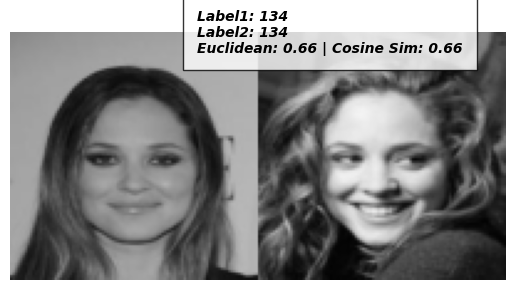

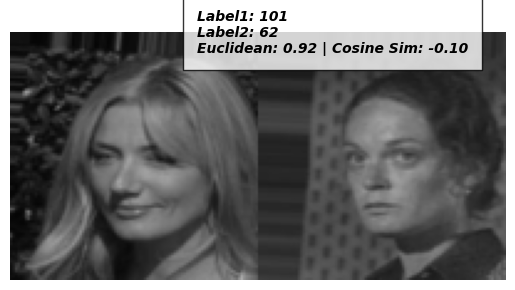

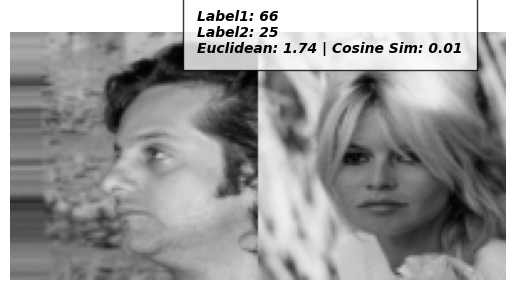

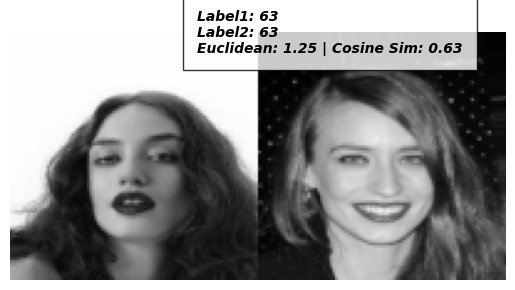

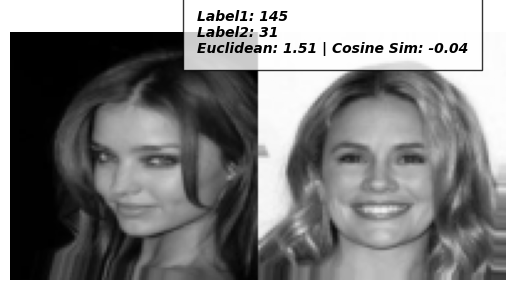

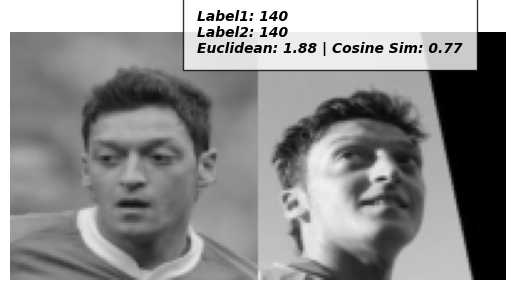

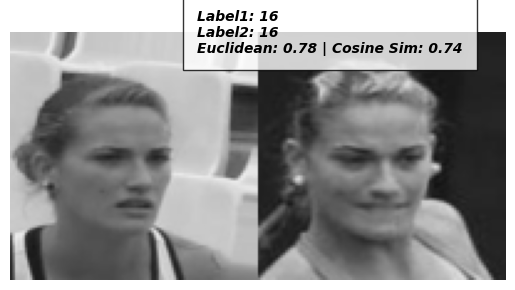

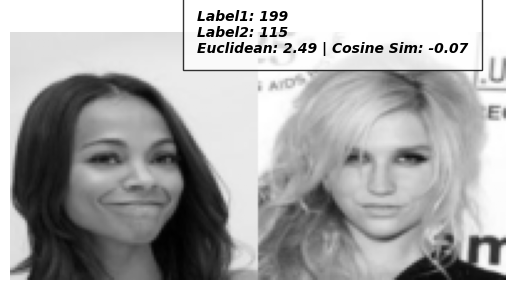

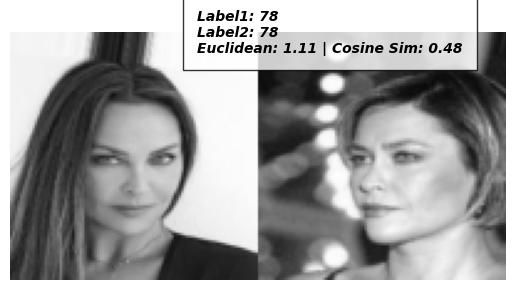

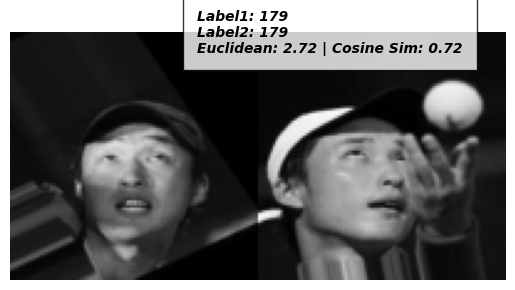

In [40]:
for i in range(10):
    # Get one sample (batch of 1)
    img1, img2, _, label1, label2 = next(iter(test_loader))

    # Get embeddings
    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))

        # Euclidean Distance
        euclidean_distance = F.pairwise_distance(emb1, emb2)
        cosine_sim = F.cosine_similarity(emb1, emb2)

    # Concatenate images side-by-side
    concatenated = torch.cat((img1[0], img2[0]), 2)

    # Convert labels to list for display
    if isinstance(label1, torch.Tensor):
        lbl1 = label1[0].cpu().numpy().tolist() if label1.dim() > 0 else label1.item()
    else:
        lbl1 = label1

    if isinstance(label2, torch.Tensor):
        lbl2 = label2[0].cpu().numpy().tolist() if label2.dim() > 0 else label2.item()
    else:
        lbl2 = label2

    title = (
        f'Label1: {lbl1}\nLabel2: {lbl2}\n'
        f'Euclidean: {euclidean_distance.item():.2f} | '
        f'Cosine Sim: {cosine_sim.item():.2f}'
    )

    imshow(torchvision.utils.make_grid(concatenated), title)


In [ ]:
# CHAT TEST
from collections import defaultdict

# 1. Alle Bilder aus test_dataloader einmalig laden und nach Label gruppieren
label_to_images = defaultdict(list)

for img, _, _, label, _ in test_loader:
    label_to_images[label.item()].append(img)

# 2. Jetzt 20 Paare mit gleichem Label erzeugen
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

net.eval()

i = 0
for label, images in label_to_images.items():
    if len(images) < 2:
        continue  # brauchen mindestens 2 Bilder mit gleichem Label

    # Erzeuge z. B. 2 zufällige Bilder dieses Labels
    img1 = images[0].to(DEVICE)
    img2 = images[1].to(DEVICE)

    with torch.no_grad():
        emb1, emb2 = net(img1, img2)
        euclidean_distance = F.pairwise_distance(emb1, emb2)
        cosine_sim = F.cosine_similarity(emb1, emb2)

    img1_gray = img1[0, 0].cpu()
    img2_gray = img2[0, 0].cpu()
    concatenated = torch.cat((img1_gray, img2_gray), dim=1)

    axs[i].imshow(concatenated.numpy(), cmap="gray")
    axs[i].set_title(
        f"Euc: {euclidean_distance.item():.2f}\nCos: {cosine_sim.item():.2f}\nLabel: {label}",
        fontsize=8
    )
    axs[i].axis("off")

    i += 1
    if i >= 20:
        break

plt.tight_layout()
plt.show()
